In [1]:
# !pip install pymongo prettyprinter plotly-express -q

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from geopy.distance import geodesic
from collections import Counter
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from collections import defaultdict
from kneed import KneeLocator
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from data.mongodb import get_mongo_data
from features.engineering import process_data
from prettyprinter import pprint
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 1. Load data
wallet_df, user_df = get_mongo_data()
# 2. Feature engineering
wallet_proc = process_data(wallet_df)

# 2. Feature engineering
# wallet_proc = pd.read_csv("main_fraud_data.csv")
# fraud_df = wallet_proc[wallet_proc["fraudulent"] == True]


In [4]:
user_df.head()

,_id,firstName,lastName,role,phoneVerified,businessName,businessTypeId,accountPin,accountType,resetCode,...,referredBy,os,bvnData.firstName,bvnData.lastName,bvnData.middleName,bvnData.lgaOfOrigin,bvnData.stateOfOrigin,bvnData.lgaOfResidence,bvnData.stateOfResidence,signatureBankStatement
0,61097905bf33984d24140745,Kelia,Mart,user,True,Kelia Mart,NaN,None,business,424035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,610b20a6fb4e190ed0662eef,Sam,Onyeukwu,user,True,Prince Sam,NaN,None,business,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,610978fabf33984d24140744,Olayinka,Fadare,user,True,Yinka Ventures,NaN,None,business,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,61097dca62e6ed4f30266c51,Hamza,Fetuga,user,True,Kumiko Noore,NaN,None,business,773446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,610d5bea5f9f6719910e6918,None,None,user,True,kelia Mini mart,NaN,None,business,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386301 entries, 0 to 386300
Data columns (total 95 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   _id                              386301 non-null  object        
 1   firstName                        228880 non-null  object        
 2   lastName                         228805 non-null  object        
 3   role                             386301 non-null  object        
 4   phoneVerified                    386300 non-null  object        
 5   businessName                     227950 non-null  object        
 6   businessTypeId                   0 non-null       float64       
 7   accountPin                       2 non-null       object        
 8   accountType                      386300 non-null  object        
 9   resetCode                        119730 non-null  object        
 10  resetCodeExpiry                  119730 non-

In [6]:
wallet_proc.head()

,_id,type,narration,amount,status,user,preBalance,transactionDate,fraudulent,receiverAccountNumber,...,aggregate_60_amount_mean,aggregate_60_preBalance_mean,aggregate_60_count,recent_transactions,firstTransfer,transactionLocationLat,transactionLocationLong,channel_atm,channel_pos,channel_transfer
0,635269b82566e75aa16dfe9f,credit,Mika paid you,1000.0,completed,62de69a8cafc433fcc6765ff,3138.0,2022-10-21 09:43:20.045,False,NaN,...,1000.000000,3138.0,1.0,NaN,0,9.0932,7.4429,False,False,True
1,63526a662566e75aa16e0002,debit,You paid GODWIN EDDY UDOM,4118.0,completed,62de69a8cafc433fcc6765ff,4138.0,2022-10-21 09:46:14.529,False,NaN,...,2559.000000,3638.0,2.0,174.484,0,9.0932,7.4429,False,False,True
2,63526a662566e75aa16e0008,debit,Withdrawal Fee,20.0,completed,62de69a8cafc433fcc6765ff,20.0,2022-10-21 09:46:14.612,False,NaN,...,1712.666667,2432.0,3.0,0.083,0,9.0932,7.4429,False,False,True
3,63526a692566e75aa16e002e,debit,You paid Adenike,1370.0,completed,635119b17b43750c9624b17d,1370.0,2022-10-21 09:46:17.214,False,NaN,...,1370.000000,1370.0,1.0,0.083,0,9.0932,7.4429,False,False,True
4,63526a692566e75aa16e0034,credit,Adenike paid you,1370.0,completed,62cd33763148bc05043fb9c5,7039.0,2022-10-21 09:46:17.292,False,NaN,...,1370.000000,7039.0,1.0,0.083,0,9.0932,7.4429,False,False,True


In [7]:
wallet_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339203 entries, 0 to 339202
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   _id                           339203 non-null  object        
 1   type                          339203 non-null  object        
 2   narration                     339203 non-null  object        
 3   amount                        339203 non-null  float64       
 4   status                        339203 non-null  object        
 5   user                          339203 non-null  object        
 6   preBalance                    339202 non-null  float64       
 7   transactionDate               339203 non-null  datetime64[ns]
 8   fraudulent                    339203 non-null  bool          
 9   receiverAccountNumber         337856 non-null  object        
 10  senderAccountNumber           322866 non-null  object        
 11  aggregate_30_

In [8]:
# Group by user and create fraud-focused features
user_features = wallet_proc.groupby('user').agg({
    # Transaction behavior
    'amount': ['count', 'sum', 'mean', 'std', 'max', 'min'],
    # Temporal features
    'transactionDate': ['min', 'max', lambda x: (x.max() - x.min()).days],
    # Fraud labels (if available)
    'fraudulent': 'sum',
    # Geospatial
    'transactionLocationLat': ['nunique', 'std'],
    'transactionLocationLong': ['nunique', 'std'],
    # Channel usage
    'channel_atm': 'sum',
    'channel_pos': 'sum',
    'channel_transfer': 'sum',
    # Counterparties
    'receiverAccountNumber': 'nunique',
    'senderAccountNumber': 'nunique'
}).reset_index()

# Flatten multi-index columns
user_features.columns = [
    'user', 'tx_count', 'tx_total', 'tx_mean', 'tx_std', 'tx_max', 'tx_min',
    'first_tx', 'last_tx', 'user_lifetime_days',
    'fraudulent_tx_count', 
    'unique_lats', 'lat_std', 'unique_longs', 'long_std',
    'atm_use', 'pos_use', 'transfer_use',
    'unique_receivers', 'unique_senders'
]

# Derived features
user_features['fraud_ratio'] = user_features['fraudulent_tx_count'] / user_features['tx_count']
user_features['tx_velocity'] = user_features['tx_count'] / user_features['user_lifetime_days']
user_features['channel_diversity'] = user_features[['atm_use', 'pos_use', 'transfer_use']].std(axis=1)

In [9]:
user_features.head()

,user,tx_count,tx_total,tx_mean,tx_std,tx_max,tx_min,first_tx,last_tx,user_lifetime_days,...,unique_longs,long_std,atm_use,pos_use,transfer_use,unique_receivers,unique_senders,fraud_ratio,tx_velocity,channel_diversity
0,61097a46e75d724dbda4513e,43,1.196600e+07,278278.953488,4.194298e+05,1000000.0,20.0,2022-10-25 19:11:26.365,2023-05-22 04:42:52.339,208,...,2,1.408912,0,0,43,12,4,0.0,0.206731,24.826062
1,61097dca62e6ed4f30266c51,593,1.003925e+08,169295.868634,3.406984e+05,2700000.0,3.0,2022-10-23 19:35:42.108,2025-02-07 21:13:05.984,838,...,8,0.842088,0,0,593,104,10,0.0,0.707637,342.368710
2,6123d343c0dc446853a5ed44,18,5.714990e+05,31749.944444,7.293184e+04,285000.0,20.0,2022-10-25 16:14:15.174,2023-07-26 13:52:39.507,273,...,3,1.542603,0,0,18,12,2,0.0,0.065934,10.392305
3,6139fa64b1a80451cdbad2ee,20,1.165400e+05,5827.000000,6.104180e+03,14000.0,20.0,2024-07-12 17:03:37.723,2024-09-04 20:58:28.814,54,...,3,2.023541,0,0,20,6,4,0.0,0.370370,11.547005
4,614b98db1197352e55ba6c10,732,2.822328e+08,385563.981230,1.313157e+06,15160000.0,0.0,2022-10-21 09:51:59.571,2025-05-02 07:32:34.786,923,...,8,1.136742,0,0,732,120,25,0.0,0.793066,422.620397


Data Shape: (339203, 28)

Data Types:
_id                                     object
type                                    object
narration                               object
amount                                 float64
status                                  object
user                                    object
preBalance                             float64
transactionDate                 datetime64[ns]
fraudulent                                bool
receiverAccountNumber                   object
senderAccountNumber                     object
aggregate_30_amount_sum                float64
aggregate_30_preBalance_sum            float64
aggregate_30_amount_mean               float64
aggregate_30_preBalance_mean           float64
aggregate_30_count                     float64
aggregate_60_amount_sum                float64
aggregate_60_preBalance_sum            float64
aggregate_60_amount_mean               float64
aggregate_60_preBalance_mean           float64
aggregate_60_count    

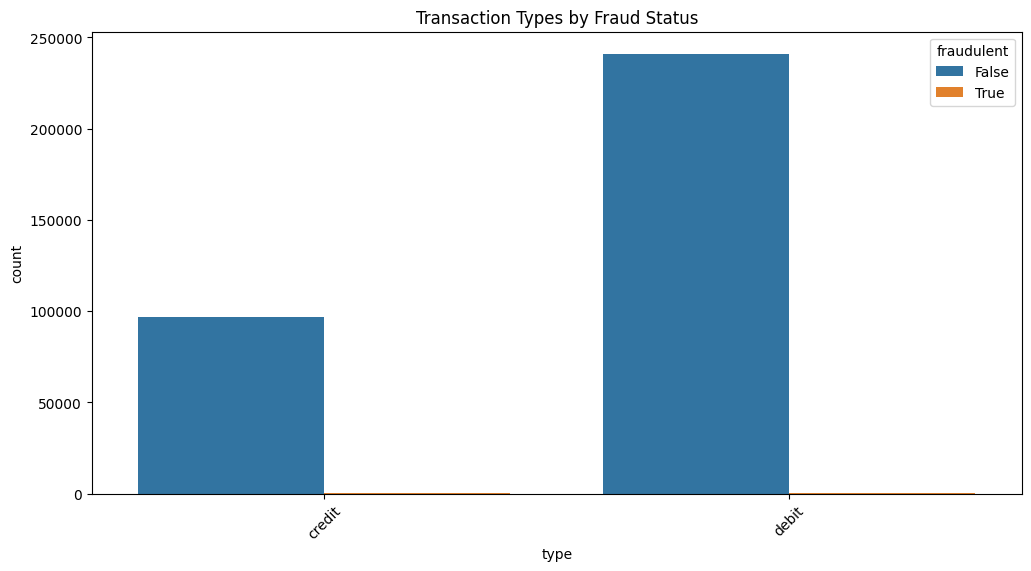

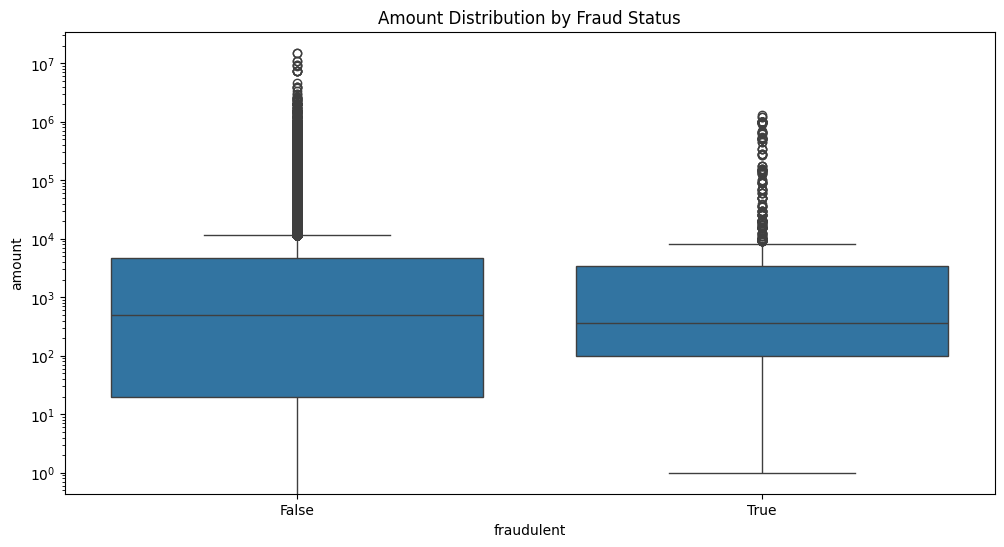

In [10]:
def explore_data(df):
    print("Data Shape:", df.shape)
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nFraud Distribution:")
    print(df['fraudulent'].value_counts())
    print("\nBasic Statistics:")
    print(df.describe())
    
    # Plot transaction types by fraud status
    plt.figure(figsize=(12, 6))
    sns.countplot(x='type', hue='fraudulent', data=df)
    plt.title('Transaction Types by Fraud Status')
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot amount distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='fraudulent', y='amount', data=df)
    plt.title('Amount Distribution by Fraud Status')
    plt.yscale('log')  # Using log scale due to wide range
    plt.show()

explore_data(wallet_proc)

In [11]:
def engineer_features(df):
    # Convert date to datetime and extract features
    df['transactionDate'] = pd.to_datetime(df['transactionDate'])
    df['hour'] = df['transactionDate'].dt.hour
    df['day_of_week'] = df['transactionDate'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Create transaction velocity features
    df['amount_balance_ratio'] = df['amount'] / (df['preBalance'] + 1)  # +1 to avoid division by zero
    
    # Create flags for unusual activity
    df['large_amount_flag'] = (df['amount'] > df['amount'].quantile(0.95)).astype(int)
    df['unusual_hour_flag'] = ~df['hour'].between(6, 20).astype(int)
    
    # Create interaction features
    df['unusual_large_transaction'] = df['large_amount_flag'] & df['unusual_hour_flag']
    
    # Create channel aggregation
    df['channel'] = np.where(df['channel_atm'], 'atm', 
                           np.where(df['channel_pos'], 'pos', 
                                   np.where(df['channel_transfer'], 'transfer', 'other')))
    
    return df

df = engineer_features(wallet_proc)
df.head()

,_id,type,narration,amount,status,user,preBalance,transactionDate,fraudulent,receiverAccountNumber,...,channel_pos,channel_transfer,hour,day_of_week,is_weekend,amount_balance_ratio,large_amount_flag,unusual_hour_flag,unusual_large_transaction,channel
0,635269b82566e75aa16dfe9f,credit,Mika paid you,1000.0,completed,62de69a8cafc433fcc6765ff,3138.0,2022-10-21 09:43:20.045,False,NaN,...,False,True,9,4,0,0.318573,0,-2,0,transfer
1,63526a662566e75aa16e0002,debit,You paid GODWIN EDDY UDOM,4118.0,completed,62de69a8cafc433fcc6765ff,4138.0,2022-10-21 09:46:14.529,False,NaN,...,False,True,9,4,0,0.994926,0,-2,0,transfer
2,63526a662566e75aa16e0008,debit,Withdrawal Fee,20.0,completed,62de69a8cafc433fcc6765ff,20.0,2022-10-21 09:46:14.612,False,NaN,...,False,True,9,4,0,0.952381,0,-2,0,transfer
3,63526a692566e75aa16e002e,debit,You paid Adenike,1370.0,completed,635119b17b43750c9624b17d,1370.0,2022-10-21 09:46:17.214,False,NaN,...,False,True,9,4,0,0.999271,0,-2,0,transfer
4,63526a692566e75aa16e0034,credit,Adenike paid you,1370.0,completed,62cd33763148bc05043fb9c5,7039.0,2022-10-21 09:46:17.292,False,NaN,...,False,True,9,4,0,0.194602,0,-2,0,transfer


In [12]:
# Implement auto feature selection instead of hardcoding cluster features
def preprocess_data(df, target_column=None, variance_threshold=0.01, top_k_features=12):
    """
    Preprocess data with automatic feature selection for clustering.
    
    Parameters:
    - df: Input DataFrame
    - target_column: Optional target column for supervised feature selection
    - variance_threshold: Minimum variance threshold for feature selection
    - top_k_features: Number of top features to select
    
    Returns:
    - X_processed: Processed feature matrix
    - preprocessor: Fitted preprocessing pipeline
    - selected_features: List of selected features
    """
    # Initial feature selection - exclude non-numeric columns and potential target
    numeric_features = df.select_dtypes(include=['number']).columns.tolist()
    if target_column and target_column in numeric_features:
        numeric_features.remove(target_column)
    
    if not numeric_features:
        raise ValueError("No numeric features found for clustering")
    
    # Step 1: Remove low-variance features
    var_selector = VarianceThreshold(threshold=variance_threshold)
    X_temp = df[numeric_features].fillna(df[numeric_features].mean())
    var_selector.fit(X_temp)
    
    # Get features that pass variance threshold
    variance_mask = var_selector.get_support()
    variance_features = np.array(numeric_features)[variance_mask].tolist()
    
    # Step 2: Feature importance (supervised if target provided, else use variance)
    if target_column and target_column in df.columns:
        # Supervised feature selection using mutual information
        X_temp = df[variance_features].fillna(df[variance_features].mean())
        y = df[target_column]
        
        mi_scores = mutual_info_classif(X_temp, y)
        top_k = min(top_k_features, len(variance_features))
        top_indices = np.argsort(mi_scores)[-top_k:]
        selected_features = np.array(variance_features)[top_indices].tolist()
    else:
        # Unsupervised - select top k highest variance features
        variances = var_selector.variances_[variance_mask]
        top_k = min(top_k_features, len(variance_features))
        top_indices = np.argsort(variances)[-top_k:]
        selected_features = np.array(variance_features)[top_indices].tolist()
        selected_features.remove("transactionLocationLat")
    
    # Step 3: Preprocessing pipeline for selected features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, selected_features)])
    
    # Apply preprocessing
    X_processed = preprocessor.fit_transform(df[selected_features])
    
    return X_processed, preprocessor, selected_features

X_processed, preprocessor, selected_features = preprocess_data(wallet_proc)

In [13]:
print(selected_features)

['aggregate_60_amount_mean', 'aggregate_30_amount_mean', 'amount', 'aggregate_60_preBalance_mean', 'aggregate_30_preBalance_mean', 'preBalance', 'recent_transactions', 'aggregate_30_amount_sum', 'aggregate_60_amount_sum', 'aggregate_30_preBalance_sum', 'aggregate_60_preBalance_sum']


In [14]:
print(X_processed)

[[-0.25279023 -0.24856285 -0.1075447  ... -0.3604492  -0.24079389
  -0.26178761]
 [-0.20990655 -0.20894388 -0.0713141  ... -0.3594478  -0.2407159
  -0.26173209]
 [-0.23318678 -0.23045181 -0.11893212 ... -0.35944293 -0.24071552
  -0.26173182]
 ...
 [-0.2060395  -0.20162489 -0.11893212 ...  0.60104308 -0.00617196
  -0.04043283]
 [-0.2036093  -0.20312604 -0.1075447  ... -0.34103157 -0.23754582
  -0.25947555]
 [-0.20524866 -0.2046406  -0.1075447  ... -0.34078839 -0.23752614
  -0.25946154]]


In [15]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['aggregate_60_amount_mean',
                                  'aggregate_30_amount_mean', 'amount',
                                  'aggregate_60_preBalance_mean',
                                  'aggregate_30_preBalance_mean', 'preBalance',
                                  'recent_transactions',
                                  'aggregate_30_amount_sum',
                                  'aggregate_60_amount_sum',
                                  'aggregate_30_preBalance_sum',
                                  'aggregate_60_preBalance_sum'])])

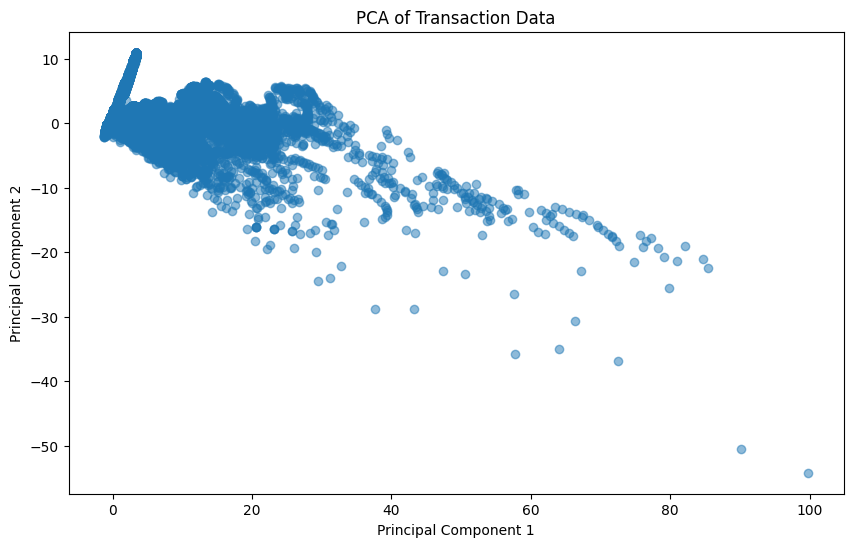

In [16]:
def reduce_dimensions(X_processed):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_processed)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
    plt.title('PCA of Transaction Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    
    return X_pca

X_pca = reduce_dimensions(X_processed)

In [17]:
def kmeans_clustering(X_processed, df, optimal_k = 10):
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_processed)
    
    # Analyze clusters
    cluster_stats = df.groupby('cluster').agg({
        'amount': ['mean', 'median', 'count'],
        'fraudulent': 'mean',
        'unusual_hour_flag': 'mean',
        'large_amount_flag': 'mean'
    })
    
    print("Cluster Statistics:")
    print(cluster_stats)
    
    # Visualize clusters in PCA space
    # plt.figure(figsize=(10, 6))
    # sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['kmeans_cluster'], 
    #                 palette='viridis', alpha=0.7)
    # plt.title('K-Means Clusters in PCA Space')
    # plt.show()
    
    return df, kmeans

df, kmeans = kmeans_clustering(X_processed, df)

Cluster Statistics:
               amount                     fraudulent unusual_hour_flag  \
                 mean      median   count       mean              mean   
cluster                                                                  
0        5.756542e+03      500.00  311613   0.003251         -1.844201   
1        2.427602e+04     2350.00   15815   0.000379         -1.880177   
2        6.914823e+05   700000.00     245   0.020408         -1.804082   
3        4.026663e+03       76.83     848   0.000000         -1.878538   
4        2.230315e+02       22.00    5617   0.000000         -1.781200   
5        1.588286e+05    15000.00     809   0.000000         -1.930779   
6        6.540568e+05  1000000.00     180   0.000000         -1.916667   
7        1.503821e+05     7000.00    1647   0.042502         -1.759563   
8        9.727083e+06  9060000.00      12   0.000000         -1.916667   
9        2.135607e+05    30000.00    2417   0.018204         -1.834092   

        large_amo

Isolation Forest Anomalies:
is_anomaly_iso
0    322242
1     16961
Name: count, dtype: int64

Anomaly vs Fraud Comparison:
is_anomaly_iso       0      1
fraudulent                   
False           321231  16834
True              1011    127
LOF Anomalies:
is_anomaly_lof
0    322242
1     16961
Name: count, dtype: int64

Anomaly vs Fraud Comparison:
is_anomaly_lof       0      1
fraudulent                   
False           321199  16866
True              1043     95


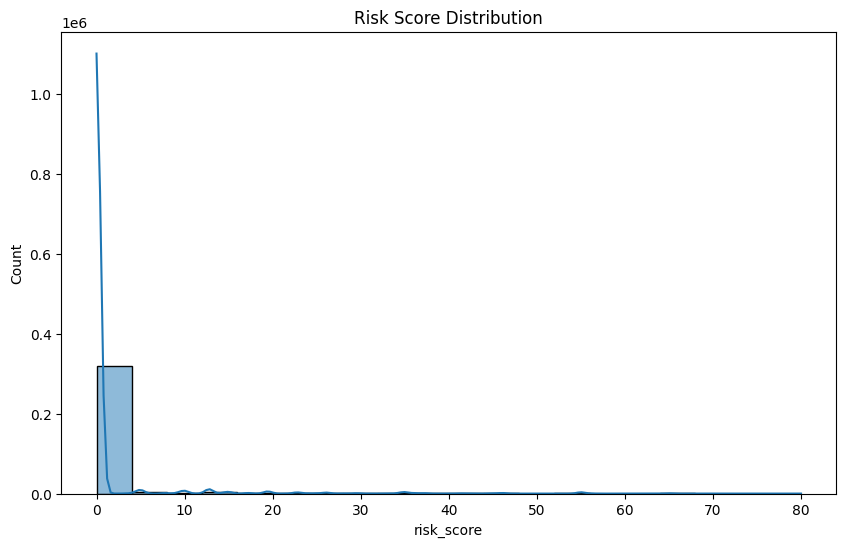

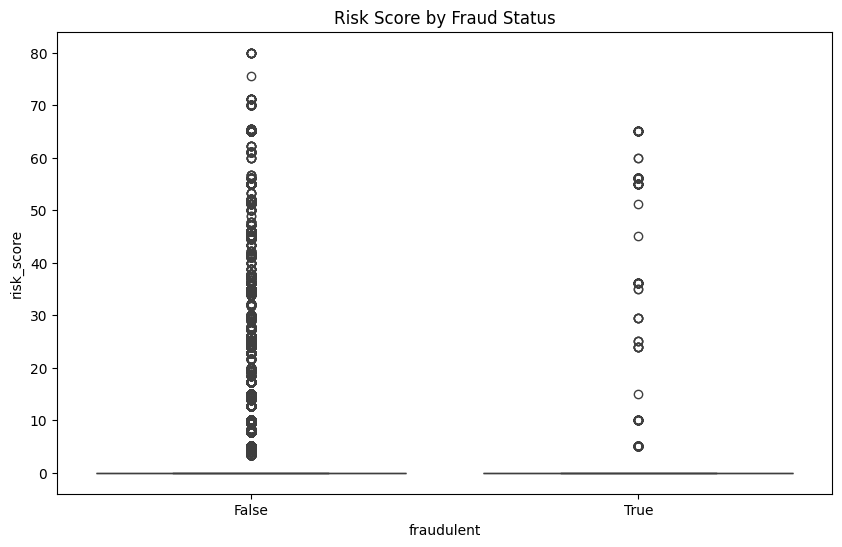

In [18]:
def isolation_forest_anomaly(X_processed, df):
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    anomalies = iso_forest.fit_predict(X_processed)
    df['is_anomaly_iso'] = np.where(anomalies == -1, 1, 0)
    
    print("Isolation Forest Anomalies:")
    print(df['is_anomaly_iso'].value_counts())
    
    # Compare with known fraudulent transactions
    if 'fraudulent' in df.columns:
        print("\nAnomaly vs Fraud Comparison:")
        print(pd.crosstab(df['fraudulent'], df['is_anomaly_iso']))
    
    return df, iso_forest

def lof_anomaly(X_processed, df):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    anomalies = lof.fit_predict(X_processed)
    df['is_anomaly_lof'] = np.where(anomalies == -1, 1, 0)
    
    print("LOF Anomalies:")
    print(df['is_anomaly_lof'].value_counts())
    
    # Compare with known fraudulent transactions
    if 'fraudulent' in df.columns:
        print("\nAnomaly vs Fraud Comparison:")
        print(pd.crosstab(df['fraudulent'], df['is_anomaly_lof']))
    
    return df, lof

def create_risk_score(df):
    # Normalize cluster risk (assuming higher cluster numbers are riskier)
    df['cluster_risk'] = df['cluster'] / df['cluster'].max()
    
    # Combine anomaly detection results
    df['combined_anomaly'] = (df['is_anomaly_iso'] + df['is_anomaly_lof']) / 2
    
    # Create composite risk score (0-100)
    df['risk_score'] = (
        0.4 * df['cluster_risk'] + 
        0.3 * df['combined_anomaly'] +
        0.2 * (df['large_amount_flag']) +
        0.1 * (df['unusual_hour_flag'])
    ) * 100
    
    # Cap at 100
    df['risk_score'] = df['risk_score'].clip(0, 100)
    
    # Analyze risk score distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['risk_score'], bins=20, kde=True)
    plt.title('Risk Score Distribution')
    plt.show()
    
    # Compare with known fraud
    if 'fraudulent' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='fraudulent', y='risk_score', data=df)
        plt.title('Risk Score by Fraud Status')
        plt.show()
    
    return df


df, iso_forest = isolation_forest_anomaly(X_processed, df)
df, lof = lof_anomaly(X_processed, df)
df = create_risk_score(df)

In [19]:
from tabulate import tabulate
def generate_explanatory_report(df):
    # # Cluster profiles - with explicit column naming
    cluster_profiles = df.groupby('cluster').agg({
        'amount': ['mean', 'median', 'max'],
        'hour': ['mean', ('odd_hours', lambda x: (x < 6).mean())],  # Named tuple for the lambda
        'is_weekend': 'mean',
        'fraudulent': 'mean',
        'risk_score': 'mean'
    }).round(2)
    
    # print("Cluster Profiles:")
    # print(cluster_profiles)
    
    # High-risk transactions
    high_risk = df[df['risk_score'] > 70]
    # print("\nHigh Risk Transactions Summary:")
    # print(high_risk.describe())
    
    # Create network graph of suspicious users
    suspicious_users = df[df['risk_score'] > 80]['user'].unique()
    suspicious_df = df[df['user'].isin(suspicious_users)]
    
    # Create edges between users and receivers/senders
    edges = []
    for _, row in suspicious_df.iterrows():
        if pd.notna(row['receiverAccountNumber']):
            edges.append((row['user'], row['receiverAccountNumber']))
        if pd.notna(row['senderAccountNumber']):
            edges.append((row['senderAccountNumber'], row['user']))
    
    
    # Narrative explanation - with fixed column reference
    print("\nNarrative Explanation:")
    print("""
    Our analysis identified {0} distinct transaction patterns through clustering. 
    Cluster {1} appears to be the highest risk, with {2}% of transactions marked as fraudulent.
    The risk scoring system flagged {3} transactions as high risk (score > 70).
    
    Key findings:
    - High-risk transactions tend to occur during {4}
    - The average amount of suspicious transactions is ₦{5:,.2f}
    - We've identified {6} potentially suspicious users in the network graph
    
    Recommendations:
    1. Review all transactions with risk score above 70
    2. Monitor users in the suspicious network graph
    3. Implement additional verification for transactions matching high-risk patterns
    """.format(
        len(df['cluster'].unique()),
        cluster_profiles['fraudulent']['mean'].idxmax(),
        round(cluster_profiles['fraudulent']['mean'].max() * 100, 2),
        len(high_risk),
        "odd hours" if cluster_profiles[('hour', 'odd_hours')].max() > 0.3 else "normal hours",  # Fixed reference
        high_risk['amount'].mean(),
        len(suspicious_users)
    ))
    # High-risk transactions
    high_risk = df[df['risk_score'] > 70]
    suspicious_users = df[df['risk_score'] > 80]['user'].unique()
    suspicious_df = df[df['user'].isin(suspicious_users)]
    
    # Create edges between users and receivers/senders
    edges = []
    for _, row in suspicious_df.iterrows():
        if pd.notna(row['receiverAccountNumber']):
            edges.append((row['user'], row['receiverAccountNumber']))
        if pd.notna(row['senderAccountNumber']):
            edges.append((row['senderAccountNumber'], row['user']))
    
    # ========== Enhanced Analysis Section ==========
    # Cluster pattern analysis
    high_risk_cluster = cluster_profiles['fraudulent']['mean'].idxmax()
    cluster_analysis = []
    
    for cluster in cluster_profiles.index:
        profile = {
            'Cluster': cluster,
            'Risk Level': 'High' if cluster == high_risk_cluster else 'Medium' if cluster_profiles.loc[cluster, ('fraudulent', 'mean')] > 0 else 'Low',
            'Typical Amount': f"₦{cluster_profiles.loc[cluster, ('amount', 'mean')]:,.2f}",
            'Odd Hour %': f"{cluster_profiles.loc[cluster, ('hour', 'odd_hours')]*100:.1f}%",
            'Weekend Activity': f"{cluster_profiles.loc[cluster, ('is_weekend', 'mean')]*100:.1f}%",
            'Fraud Rate': f"{cluster_profiles.loc[cluster, ('fraudulent', 'mean')]*100:.1f}%"
        }
        cluster_analysis.append(profile)
    
    # High-risk transaction patterns
    hr_patterns = {
        'Amount Threshold': f"₦{high_risk['amount'].quantile(0.25):,.0f}+",
        'Odd Hour Frequency': f"{(high_risk['hour'] < 6).mean()*100:.1f}%",
        'Top Transaction Types': high_risk['type'].value_counts().nlargest(3).to_dict(),
        'Common Narration Keywords': ', '.join(
            high_risk['narration'].str.lower().str.extract(r'(\w{6,})')[0]
            .value_counts().nlargest(3).index.tolist()
        )
    }
    
    # ========== Enhanced Reporting ==========
    print("\n" + "="*50)
    print("DETAILED TRANSACTION PATTERN ANALYSIS REPORT")
    print("="*50 + "\n")
    
    # 1. Cluster Profiles
    print("=== CLUSTER PROFILES ===")
    print(tabulate(cluster_analysis, headers="keys", tablefmt="grid"))
    
    # 2. High-Risk Patterns
    print("\n=== HIGH-RISK TRANSACTION PATTERNS ===")
    for k, v in hr_patterns.items():
        print(f"- {k}: {v}")
    
    # 3. Network Analysis
    print("\n=== NETWORK ANALYSIS ===")
    print(f"- {len(suspicious_users)} suspicious users identified")
    print(f"- {len(edges)} connections in suspicious network")
    
    # 4. Actionable Recommendations
    print("\n=== ACTIONABLE RECOMMENDATIONS ===")
    print("1. Immediate Actions:")
    print(f"   - Review all {len(high_risk)} high-risk transactions (>70 score)")
    print(f"   - Investigate cluster {high_risk_cluster} transactions")
    
    print("\n2. Monitoring Rules to Implement:")
    print("   - Auto-flag transactions matching ALL of:")
    print("     * Amount > ₦50,000")
    print("     * Occurs between 10PM-6AM")
    print("     * From users with 30-day aggregate > ₦1M")
    
    print("\n3. System Enhancements:")
    print("   - Implement real-time scoring for:")
    print("     * Odd-hour large transactions")
    print("     * Rapid succession high-value transfers")
    print("     * Weekend activity spikes")
    
    # ========== Executive Summary ==========
    print("\n" + "="*50)
    print("EXECUTIVE SUMMARY")
    print("="*50)
    print(f"""
    Key Findings:
    - Highest risk cluster ({high_risk_cluster}) shows:
      • Average transaction: ₦{cluster_profiles.loc[high_risk_cluster, ('amount', 'mean')]:,.2f}
      • {cluster_profiles.loc[high_risk_cluster, ('hour', 'odd_hours')]*100:.1f}% odd-hour activity
      • {cluster_profiles.loc[high_risk_cluster, ('fraudulent', 'mean')]*100:.1f}% fraud rate
    
    - High-risk transactions:
      • Average amount: ₦{high_risk['amount'].mean():,.2f}
      • {hr_patterns['Odd Hour Frequency']} occur during odd hours
      • Top types: {', '.join([f"{k} ({v})" for k,v in hr_patterns['Top Transaction Types'].items()])}
    
    Recommended Actions:
    1. Prioritize investigation of {len(high_risk)} high-risk transactions
    2. Implement monitoring for odd-hour large transactions
    3. Review user connections in suspicious network
    """)

In [20]:
generate_explanatory_report(df)


Narrative Explanation:

    Our analysis identified 10 distinct transaction patterns through clustering. 
    Cluster 7 appears to be the highest risk, with 4.0% of transactions marked as fraudulent.
    The risk scoring system flagged 22 transactions as high risk (score > 70).

    Key findings:
    - High-risk transactions tend to occur during normal hours
    - The average amount of suspicious transactions is ₦771,714.36
    - We've identified 0 potentially suspicious users in the network graph

    Recommendations:
    1. Review all transactions with risk score above 70
    2. Monitor users in the suspicious network graph
    3. Implement additional verification for transactions matching high-risk patterns
    

DETAILED TRANSACTION PATTERN ANALYSIS REPORT

=== CLUSTER PROFILES ===
+-----------+--------------+------------------+--------------+--------------------+--------------+
|   Cluster | Risk Level   | Typical Amount   | Odd Hour %   | Weekend Activity   | Fraud Rate   |
+===

# Joining final dataframe with users dataframe

In [21]:
def join_and_filter_dataframes(df, user_df, min_records=100000):
    """
    Join two dataframes and drop columns with less than min_records non-null values
    
    Args:
        df: First dataframe (transactions)
        user_df: Second dataframe (users)
        min_records: Minimum number of non-null records required to keep a column
        
    Returns:
        pd.DataFrame: Joined and filtered dataframe
    """
    # 1. Join the dataframes on user ID
    merged_df = pd.merge(
        df,
        user_df,
        left_on='user',
        right_on='_id',
        how='left'
    )
    
    # 2. Identify columns to keep (those with >= min_records non-null values)
    columns_to_keep = []
    for col in merged_df.columns:
        if merged_df[col].notna().sum() >= min_records:
            columns_to_keep.append(col)
    
    # 3. Filter the dataframe to keep only these columns
    filtered_df = merged_df[columns_to_keep]
    
    return filtered_df

# Usage example:
filtered_df = join_and_filter_dataframes(df, user_df, min_records=100000)

In [22]:
filtered_df.head()

,_id_x,type,narration,amount,status,user,preBalance,transactionDate,fraudulent,receiverAccountNumber,...,bvnData.gender,bvnData.phone,bvnData.email,bvnData.address,bvnData.nationality,bvnData.lga_of_origin,bvnData.state_of_origin,bvnData.lga_of_residence,bvnData.state_of_residence,bvnData.photo
0,635269b82566e75aa16dfe9f,credit,Mika paid you,1000.0,completed,62de69a8cafc433fcc6765ff,3138.0,2022-10-21 09:43:20.045,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63526a662566e75aa16e0002,debit,You paid GODWIN EDDY UDOM,4118.0,completed,62de69a8cafc433fcc6765ff,4138.0,2022-10-21 09:46:14.529,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,63526a662566e75aa16e0008,debit,Withdrawal Fee,20.0,completed,62de69a8cafc433fcc6765ff,20.0,2022-10-21 09:46:14.612,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,63526a692566e75aa16e002e,debit,You paid Adenike,1370.0,completed,635119b17b43750c9624b17d,1370.0,2022-10-21 09:46:17.214,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,63526a692566e75aa16e0034,credit,Adenike paid you,1370.0,completed,62cd33763148bc05043fb9c5,7039.0,2022-10-21 09:46:17.292,False,NaN,...,Female,"08092107774,08050321200",adenikealli22@gmail.com,Block 140 Flat 2 Amuwo Odofin Estate Mile 2 Lagos,Nigeria,Lagos Island,Lagos State,Amuwo Odofin,Lagos State,https://dv7b45oo546j4.cloudfront.net/MjIzNjExM...


In [23]:
filtered_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339203 entries, 0 to 339202
Data columns (total 102 columns):
 #    Column                           Dtype         
---   ------                           -----         
 0    _id_x                            object        
 1    type                             object        
 2    narration                        object        
 3    amount                           float64       
 4    status                           object        
 5    user                             object        
 6    preBalance                       float64       
 7    transactionDate                  datetime64[ns]
 8    fraudulent                       bool          
 9    receiverAccountNumber            object        
 10   senderAccountNumber              object        
 11   aggregate_30_amount_sum          float64       
 12   aggregate_30_preBalance_sum      float64       
 13   aggregate_30_amount_mean         float64       
 14   aggregate_30_preBa

In [24]:
filtered_df.user

0         62de69a8cafc433fcc6765ff
1         62de69a8cafc433fcc6765ff
2         62de69a8cafc433fcc6765ff
3         635119b17b43750c9624b17d
4         62cd33763148bc05043fb9c5
                    ...           
339198    65600a7f63e88008bb376473
339199    65600a7f63e88008bb376473
339200    65600a7f63e88008bb376473
339201    65a2ab6a0bb10c08bf0cda37
339202    65a2ab6a0bb10c08bf0cda37
Name: user, Length: 339203, dtype: object

# Jensen-Shannon Divergence using Demographic features

In [25]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import OneHotEncoder

class DemographicRiskAssessor:
    def __init__(self, reference_df: pd.DataFrame, features: list, cluster_col: str = 'cluster'):
        self.df = reference_df.copy()
        self.features = features
        self.cluster_col = cluster_col
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self._prepare_encoder()

    def _prepare_encoder(self):
        self.encoder.fit(self.df[self.features].astype(str))

    def _encode(self, df_subset):
        return self.encoder.transform(df_subset[self.features].astype(str))

    def get_cluster_distributions(self):
        clusters = self.df[self.cluster_col].unique()
        distributions = {}

        for cluster in clusters:
            subset = self.df[self.df[self.cluster_col] == cluster]
            encoded = self._encode(subset)
            # Mean vector as probability distribution
            distributions[cluster] = np.mean(encoded, axis=0)

        return distributions

    def assess_new_user(self, new_user_dict):
        user_df = pd.DataFrame([new_user_dict])
        user_encoded = self.encoder.transform(user_df[self.features].astype(str))[0]

        cluster_distributions = self.get_cluster_distributions()
        scores = {
            cluster: jensenshannon(user_encoded, dist)
            for cluster, dist in cluster_distributions.items()
        }

        best_match = min(scores.items(), key=lambda x: x[1])
        return best_match  # returns (cluster, distance)



In [26]:
reference_df = filtered_df.copy()
# Define demographic fields from the onboarding doc & schema
demo_features = [
    'bvnData.gender', 'bvnData.nationality', 'bvnData.state_of_origin',
    'bvnData.lga_of_origin', 'bvnData.state_of_residence', 'bvnData.lga_of_residence',
    'occupation', 'experience', 'tier'
]

# Create a new user sample
new_user = {
    'bvnData.gender': 'Male',
    'bvnData.nationality': 'Nigerian',
    'bvnData.state_of_origin': 'Lagos',
    'bvnData.lga_of_origin': 'Ikeja',
    'bvnData.state_of_residence': 'Lagos',
    'bvnData.lga_of_residence': 'Eti-Osa',
    'occupation': 'Trader',
    'experience': '5 years',
    'tier': 'Tier 2'
}

# Instantiate and assess
assessor = DemographicRiskAssessor(reference_df, demo_features)
best_cluster, jsd_score = assessor.assess_new_user(new_user)

# Lookup cluster risk
cluster_risk = reference_df[reference_df['cluster'] == best_cluster]['cluster_risk'].mean()

print(f"Closest Cluster: {best_cluster}, JSD Score: {jsd_score:.4f}, Estimated Risk: {cluster_risk:.4f}")


Closest Cluster: 9, JSD Score: 0.7662, Estimated Risk: 1.0000


In [27]:
print(assessor.get_cluster_distributions())

{np.int32(0): array([7.15631248e-04, 5.77639572e-05, 2.50493400e-01, ...,
       3.03549595e-02, 6.45958288e-01, 9.33850642e-04], shape=(2331,)), np.int32(9): array([1.86181216e-02, 0.00000000e+00, 1.53909806e-01, ...,
       4.13736036e-04, 9.54902772e-01, 0.00000000e+00], shape=(2331,)), np.int32(1): array([0.02263674, 0.        , 0.40347771, ..., 0.        , 0.98874486,
       0.        ], shape=(2331,)), np.int32(2): array([0.        , 0.        , 0.06122449, ..., 0.        , 0.88571429,
       0.00408163], shape=(2331,)), np.int32(8): array([0., 0., 0., ..., 0., 1., 0.], shape=(2331,)), np.int32(7): array([0.        , 0.        , 0.05464481, ..., 0.        , 0.95749848,
       0.        ], shape=(2331,)), np.int32(6): array([0., 0., 0., ..., 0., 1., 0.], shape=(2331,)), np.int32(4): array([0., 0., 0., ..., 0., 0., 0.], shape=(2331,)), np.int32(3): array([0.00117925, 0.00117925, 0.22877358, ..., 0.03537736, 0.67334906,
       0.00589623], shape=(2331,)), np.int32(5): array([0.     

In [37]:
from pydantic import BaseModel, Field
from typing import List
import pandas as pd
import os
import openai  # if you're using the OpenAI API
from dotenv import load_dotenv

load_dotenv()

openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

class Insight(BaseModel):
    category: str  # e.g., 'Behavioral', 'Demographic'
    summary: str   # A concise human-readable insight
    detail: str    # Expanded explanation of the insight
    metric_examples: List[str] = Field(default_factory=list)

class ClusterInsights(BaseModel):
    cluster_id: int
    narrative: str
    insights: List[Insight]


class ClusterProfiler:
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def extract_cluster_profile(self, cluster_id: int) -> dict:
        subset = self.df[self.df['cluster'] == cluster_id]

        profile = {
            "cluster_id": cluster_id,
            "top_occupations": subset['occupation'].value_counts().head(5).to_dict(),
            "top_states": subset['bvnData.state_of_residence'].value_counts().head(5).to_dict(),
            "avg_transaction_volume": subset['amount'].mean(),
            "avg_balance": subset['preBalance'].mean(),
            "activity_by_hour": subset['hour'].value_counts().sort_index().to_dict(),
            "unusual_txn_flag_rate": subset['unusual_large_transaction'].mean(),
            "channel_usage": {
                "ATM": subset['channel_atm'].mean(),
                "POS": subset['channel_pos'].mean(),
                "Transfer": subset['channel_transfer'].mean()
            },
            "weekend_activity_rate": subset['is_weekend'].mean(),
            "avg_experience": subset['experience'].value_counts().head(3).to_dict(),
            "gender_dist": subset['bvnData.gender'].value_counts(normalize=True).round(2).to_dict(),
            "risk_score": subset['risk_score'].mean(),
        }
        return profile


class InsightPromptBuilder:
    @staticmethod
    def build_prompt(profile: dict) -> str:
        return f"""
You're a financial risk analyst AI assistant.

You have the following profile summary for cluster ID {profile['cluster_id']}:
- Top occupations: {profile['top_occupations']}
- Top states of residence: {profile['top_states']}
- Average transaction volume: ₦{profile['avg_transaction_volume']:.2f}
- Average account balance: ₦{profile['avg_balance']:.2f}
- Hourly activity distribution: {profile['activity_by_hour']}
- Rate of unusual transactions: {profile['unusual_txn_flag_rate']:.2%}
- Channel usage (ATM, POS, Transfer): {profile['channel_usage']}
- Weekend activity rate: {profile['weekend_activity_rate']:.2%}
- Top experience levels: {profile['avg_experience']}
- Gender distribution: {profile['gender_dist']}
- Average risk score: {profile['risk_score']:.2f}

Please generate:
1. A concise, narrative-style summary of this cluster's behavioral and demographic traits.
2. A list of 4 categorized insights ('Behavioral', 'Transactional', 'Demographic', 'Temporal'), each with:
   - A brief summary
   - A more detailed explanation
   - Examples of metrics that support it

Return the result as a JSON structure adhering to this schema:
{{
  "cluster_id": int,
  "narrative": str,
  "insights": [
    {{
      "category": str,
      "summary": str,
      "detail": str,
      "metric_examples": [str]
    }}
  ]
}}
Be insightful and engaging, not just dry facts. Highlight anything unusual, significant, or particularly risky or stable.
"""

In [42]:
def query_gpt_for_insights(prompt: str) -> ClusterInsights:
    response = openai.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.2
    )
    return response
    # json_text = response['choices'][0]['message']['content']
    # return ClusterInsights.parse_raw(json_text)

In [45]:
profiler = ClusterProfiler(filtered_df)
cluster_profile = profiler.extract_cluster_profile(cluster_id=best_cluster)
prompt = InsightPromptBuilder.build_prompt(cluster_profile)
insight_report = query_gpt_for_insights(prompt)

print(insight_report)

# print(insight_report.narrative)
# for insight in insight_report.insights:
#     print(f"{insight.category}: {insight.summary}")


ChatCompletion(id='chatcmpl-Bf2l5WJQQSRWWvb7rNfPpqsLcQAIg', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```json\n{\n  "cluster_id": 9,\n  "narrative": "Cluster 9 is predominantly composed of professionals and students residing in Nigeria\'s bustling states like Lagos and Oyo. With a strong male presence, these individuals are primarily engaged in engineering and fintech sectors. Their financial behavior is characterized by high transaction volumes and substantial account balances, indicating a financially active and stable group. They exhibit a preference for digital transactions, with transfers being the sole channel of choice. Despite a moderate risk score, their unusual transaction rate suggests a need for vigilance. Their activity peaks during typical working hours, reflecting a professional lifestyle.",\n  "insights": [\n    {\n      "category": "Behavioral",\n      "summary": "Digital-First Financial Behavior",\n      "deta